In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import gc
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K



Using TensorFlow backend.


In [ ]:
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [ ]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'/content/drive/MyDrive/dataset_new/molecule/train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]


In [ ]:
test_csv = pd.read_csv(f'/content/drive/MyDrive/dataset_new/molecule/test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]


In [ ]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [ ]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [ ]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [ ]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [ ]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

    def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

  def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

  def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=15):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack() 
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    full.sort_values('id', inplace=True)
    
    return full

def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

Feeatures for x, y, z coordinates

In [ ]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'/content/drive/MyDrive/dataset_new/molecule/structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [ ]:
def create_nn_model(input_shape):
    inp = Input(shape=(input_shape,))
    x = Dense(2048, activation="relu")(inp)
    x = BatchNormalization()(x)
    #x = Dropout(0.4)(x)
    x = Dense(1024, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation="linear")(x)  
   # out1 = Dense(2, activation="linear")(x)#mulliken charge 2
   # out2 = Dense(6, activation="linear")(x)#tensor 6(xx,yy,zz)
   # out3 = Dense(12, activation="linear")(x)#tensor 12(others) 
   # out4 = Dense(1, activation="linear")(x)#scalar_coupling_constant 
    #model = Model(inputs=inp, outputs=[out,out1,out2,out3,out4])
    model = Model(inputs=inp, outputs=[out])
    return model

In [ ]:
def plot_history(history, label):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [ ]:
# Set up GPU preferences
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config) 
K.set_session(sess)

In [ ]:
from datetime import datetime

mol_types=train_csv["type"].unique()
cv_score=[]
cv_score_total=0
epoch_n = 1000
verbose = 1
batch_size = 2048
    
# Set to True if we want to train from scratch. False will reuse saved models as a starting point.
retrain =True

start_time=datetime.now()
test_prediction=np.zeros(len(test_csv))
input_features = ['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7',
       'atom_8','atom_9', 'atom_10','d_1_0', 'd_2_0', 'd_2_1', 'd_3_0',
       'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0',
       'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1', 'd_8_2',
       'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3', 'd_10_0', 'd_10_1', 'd_10_2',
       'd_10_3']



# Loop through each molecule type
for mol_type in mol_types:

    model_name_wrt = ('molecule_model_%s.hdf5' % mol_type)
    print('Training %s' % mol_type, 'out of', mol_types, '\n')

    full = build_couple_dataframe(train_csv, structures_csv, mol_type, n_atoms=11)
    full2 = build_couple_dataframe(test_csv, structures_csv, mol_type, n_atoms=11)
    df_train_ = take_n_atoms(full, 11)
    df_test_ = take_n_atoms(full2, 11)
    df_train_  = df_train_.fillna(0)
    df_test_  = df_test_.fillna(0)
    
    
    input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))   
    #input_data=StandardScaler().fit_transform(df_train_.loc[:,input_features])
    target_data=df_train_.loc[:,"scalar_coupling_constant"].values

    # Simple split to provide us a validation set to do our CV checks 
    train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.1)
    # Split all our input and targets by train and cv indexes
    train_target=target_data[train_index]
    cv_target=target_data[cv_index]
    train_input=input_data[train_index]
    cv_input=input_data[cv_index]
    test_input=input_data[len(df_train_):,:]

    # Build the Neural Net
    nn_model=create_nn_model(train_input.shape[1])
    
    # If retrain==False, then we load a previous saved model as a starting point.
    if not retrain:
        nn_model = load_model(model_name_rd)
        
    nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])
    
    # Callback for Early Stopping. We may want to raise the min_delta for small numbers of epochs
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=40,verbose=1, mode='auto', restore_best_weights=True)
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=30, min_lr=1e-6, mode='auto', verbose=1)
    # Save the best value of the model for future use
    sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)
    history = nn_model.fit(train_input,[train_target], 
            validation_data=(cv_input,[cv_target]), 
            callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
    
    cv_predict=nn_model.predict(cv_input)
    plot_history(history, mol_type)
    accuracy=np.mean(np.abs(cv_target-cv_predict[:,0]))
    print(np.log(accuracy))
    cv_score.append(np.log(accuracy))
    cv_score_total+=np.log(accuracy)
    
    # Predict on the test data set using our trained model
    test_predict=nn_model.predict(test_input)
    
    # for each molecule type we'll grab the predicted values
    test_prediction[test_csv["type"]==mol_type]=test_predict[:,0]
    K.clear_session()

cv_score_total/=len(mol_types)


Training 1JHC out of [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN]
Categories (8, object): [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN] 

Train on 638219 samples, validate on 70914 samples
Epoch 1/1000
638219/638219 [==============================] - 8s 13us/step - loss: 56.8017 - val_loss: 42.6837
Epoch 2/1000
638219/638219 [==============================] - 6s 9us/step - loss: 1.9383 - val_loss: 1.6408
Epoch 3/1000
638219/638219 [==============================] - 6s 9us/step - loss: 1.6443 - val_loss: 1.5989
Epoch 4/1000
638219/638219 [==============================] - 6s 10us/step - loss: 1.5274 - val_loss: 1.7923
Epoch 5/1000
638219/638219 [==============================] - 6s 9us/step - loss: 1.4556 - val_loss: 1.6517
Epoch 6/1000
638219/638219 [==============================] - 6s 9us/step - loss: 1.3869 - val_loss: 1.6125
Epoch 7/1000
638219/638219 [==============================] - 6s 9us/step - loss: 1.3602 - val_loss: 1.5085
Epoch 8/1000
638219/638219 [================

MODEL

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
# filter warnings
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [ ]:
import json, sys, random
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras import regularizers
from keras import optimizers
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from keras.utils import to_categorical

In [ ]:
#f = open(r'/content/drive/MyDrive/dataset_new/data1.json')
#dataset = json.load(f)
#f.close()
input_data = np.array(dataset['data']).astype('uint8')
labels_data = np.array(dataset['labels']).astype('uint8')

In [ ]:
n_spectrum = 3 # color chanel (RGB)
weight = 80
height = 80
X = input_data.reshape([-1, n_spectrum, weight, height])

In [ ]:
Xt=X.transpose(0,2,3,1)

In [ ]:
Presence_Absence=pd.value_counts(pd.Series(labels_data))
Presence_Absence

0    3000
1    1000
dtype: int64

In [ ]:
data_train, data_test, labels_train, labels_test = train_test_split(
    input_data,
    labels_data,
    test_size=.45, random_state=0, stratify=labels_data)

# Create validation and test sets
data_validation, data_test, labels_validation, labels_test = train_test_split(
data_test, labels_test,test_size=.20, random_state=0)

data_train=data_train.reshape(-1, n_spectrum, weight, height)
data_test=data_test.reshape(-1, n_spectrum, weight, height)
data_validation=data_validation.reshape(-1, n_spectrum, weight, height)


In [ ]:
data_t_train=data_train.transpose(0,2,3,1)
data_t_test=data_test.transpose(0,2,3,1)
data_t_validation=data_validation.transpose(0,2,3,1)

Text(0.5, 1.0, 'PCA')

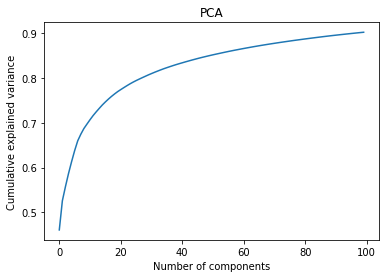

In [ ]:
pca = PCA(n_components=100)
values_train=data_train.reshape(-1,(80*80*3))
pca.fit(values_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA')

In [ ]:
NCOMPONENTS = 80
pca = PCA(n_components=NCOMPONENTS)
data_pca_train = pca.fit_transform(data_train.reshape(-1,(80*80*3)))
data_pca_val = pca.transform(data_validation.reshape(-1,(80*80*3)))
data_pca_test = pca.transform(data_test.reshape(-1,(80*80*3)))
pca_std = np.std(data_pca_train)


In [ ]:
labels_train=to_categorical(labels_train)
labels_test=to_categorical(labels_test)
labels_validation=to_categorical(labels_validation)

In [ ]:
model_fcnn = Sequential([
  Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001),input_shape=(80,)),
  Dropout(0.1),
  Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
  Dropout(0.1),
  Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
  Dropout(0.1),
  Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.0001)),
])

model_fcnn.summary()
model_fcnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

model_fcnn.fit(
  data_pca_train, # training data
  labels_train, # training targets
  validation_data=(data_pca_val, labels_validation),
  epochs=1500,
  batch_size=200
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                5184      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                

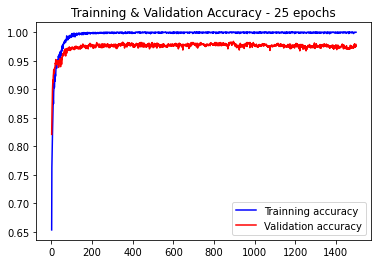

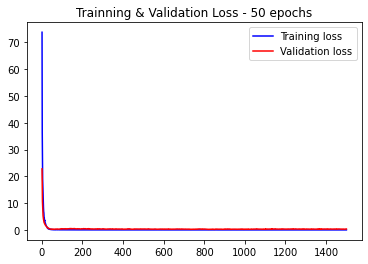

12/12 [==============================] - 0s 2ms/step - loss: 0.1726 - accuracy: 0.9778
Test loss 0.17
Test accuracy 0.98


In [ ]:
acc=model_fcnn.history.history['accuracy']
val_acc=model_fcnn.history.history['val_accuracy']
loss=model_fcnn.history.history['loss']
val_loss=model_fcnn.history.history['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'b',label='Trainning accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Trainning & Validation Accuracy - 25 epochs')
plt.legend()
plt.figure()
plt.plot(epochs,loss, 'b', label='Training loss')
plt.plot(epochs,val_loss, 'r', label='Validation loss')
plt.title('Trainning & Validation Loss - 50 epochs')
plt.legend()
plt.show()


test_loss, test_acc =model_fcnn.evaluate(
  data_pca_test,
  labels_test
)

print('Test loss', round(test_loss,2))
print('Test accuracy', round(test_acc,2))